In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# from cenpy import products
pd.options.display.max_columns =200
# pd.options.display.max_colwidth = 300
from census import Census 
import us
from us import states
import contextily as ctx


c = Census("d95e144b39e17f929287714b0b8ba9768cecdc9f",year=2018) 

# Social Vulnerability Index for Mapping Community Health Worker Need

This notebook shows preliminary mapping of the CDC's [Social Vulnerability Index](https://svi.cdc.gov/). This index is built using American Community Survey 5 year estimates (2014-2018) and is comprised of four thematic categories. Multiple ACS variables are used within each thematic category:

#### Socioeconomic Status
- below poverty level
- unemployment
- median household income
- education level (no high school diploma)  

#### Household Composition and Disability
- number of residents >65
- number of residents > 17 years
- single parent households
- disability status

#### Minority Status and Language  
- non-white population
- language spoken (speaks english "less than well")  

#### Housing and Transportation  
- multi-unit housing
- mobile homes
- crowded living conditions
- no vehicle
- group quarters

Full documentation for 2018 data is available [here](https://svi.cdc.gov/data-and-tools-download.html).


### I. Importing SVI data and computing state percentile ranking

The CDC uses both a USA-wide percentile ranking and a state by state percentile ranking. For our project given that funding is likely going to be managed at a state level using a state percentile ranking makes the most sense and will be most sensitive to regional socioeconomic differences. What do others think?

In [2]:
# import SVI data
svi = gpd.read_file("data/svi/SVI2018_US_tract.geojson")
svi_tribal = gpd.read_file("data/svi/SVI2018_tribal_tract.geojson")
svi_puerto_rico = gpd.read_file("data/svi/SVI2018_PuertoRico_tract.geojson")

In [3]:
## add in puerto rico to USA-wide dataset
svi_pr = svi.append(svi_puerto_rico)

## select just locations with non-N/A values for 'SPL_THEMES' field
svi_pr_forRPL = svi_pr[svi_pr['SPL_THEMES'] != -999].copy()
svi_pr_forRPL_na = svi_pr[svi_pr['SPL_THEMES'] == -999].copy()

## calculate state percentile rank for combined svi variable
svi_pr_forRPL['RPL_ThemesStates'] = svi_pr_forRPL.groupby('STATE')['SPL_THEMES'].rank(pct=True)

## append no data values back to dataset for complete set
svi_states = svi_pr_forRPL.append(svi_pr_forRPL_na)

In [4]:
## creating a percentile ranking by state for % uninsured population
## we may want to add 
svi_states['RPL_Uninsur'] = svi_states.groupby('STATE')['EP_UNINSUR'].rank(pct=True)

### II. Locating Essential Workers as additional SVI variable

The following estimated values for the essential workforce use ACS 5 year estimates for occupation (contained in table C24010). The occupations included in this table are shown [here](https://www2.census.gov/programs-surveys/acs/tech_docs/table_shells/2018/C24010.xlsx). A limitation of this method is that these are high level occupation classifications, each contains multiple of the Bureau of Labor Statistics SOC codes for individual occupations. 

This method draws on the method used by [the Massachussets ACLU](https://www.aclum.org/en/publications/data-show-covid-19-hitting-essential-workers-and-people-color-hardest) whose analysis uses these higher level codes. 

[New York Times](https://www.nytimes.com/2020/04/18/us/coronavirus-women-essential-workers.html) and others have used Census Microdata 1% samples which have more granular occupation classifications but are only available at a larger geographic scale (PUMA). 

The maps below follow the classification scheme of the ACLU which classifies essential workers as:
- Healthcare practitioners and technical occupations: 
    - Health diagnosing and treating practitioners and other technical occupations 
    - Health technologists and technicians 
- Service occupations: 
    - Healthcare support occupations 
    - Protective service occupations: 
        - Firefighting and prevention, and other protective service workers including supervisors 
        - Law enforcement workers including supervisors 
    - Food preparation and serving related occupations 
    - Building and grounds cleaning and maintenance occupations 
    - Personal care and service occupations 
- Sales and office occupations: 
    - Sales and related occupations 
    - Office and administrative support occupations 
- Natural resources, construction, and maintenance occupations: 
    - Farming, fishing, and forestry occupations 
    - Construction and extraction occupations 
    - Installation, maintenance, and repair occupations 
- Production, transportation, and material moving occupations: 
    - Production occupations 
    - Transportation occupations 
    - Material moving occupations

### Downloading ACS occupations
Using [table C24010](https://api.census.gov/data/2018/acs/acs5/groups/C24010.html): Sex by Occupation for the Civilian Employed Population 16 years and over  
Relevant Variables are C24010_001E - C24010_073E

In [5]:
## creating a list of ACS variables for C24010_001E - C24010_073E
counter = []
i = 1
while i < 74:
    counter.append(i)
    i += 1

var_lst = pd.DataFrame(counter)
var_lst['prefix'] = 'C24010_0'
var_lst['counter'] = var_lst[0].astype(str).str.zfill(2)
var_lst['var'] = var_lst['prefix']+var_lst['counter']+'E'
occ_var = var_lst['var'].tolist()
occ_var.append('NAME')

In [6]:
## getting a list of fips codes for all U.S states
fips_all = us.states.mapping('fips','abbr')
fips_df = pd.DataFrame.from_dict(fips_all,orient='index').reset_index()
state_fips = fips_df['index'].tolist()


In [ ]:
## pulling census data for tracts in all states
usa_essential = []
for i,val in enumerate(state_fips):
    temp = c.acs5.get((occ_var),geo={'for':'tract:*','in':'state:{}'.format(val)})
#     print('state:{}'.format(val))
    usa_essential.append(temp)
for_df = []
for i, item in enumerate(usa_essential):
    for_df.extend(item)

In [39]:
## unwrap and create dataframe
## downloaded data includes blank states 
## where there is no data for this variables
subset_usa = usa_essential[0:50]

## create empty dataframe
occupations_usa = pd.DataFrame(columns = occ_var)

## iterate over list of state dictionaries
for i,val in enumerate(subset_usa):
    temp_df = pd.DataFrame(subset_usa[i])
    occupations_usa = occupations_usa.append(temp_df)


In [43]:
## calculating percent essential
ess_list = ['C24010_016E','C24010_019E',
 'C24010_027E','C24010_030E','C24010_034E','C24010_052E',
 'C24010_055E','C24010_063E','C24010_066E','C24010_070E']
total_lst = ['']
occupations_usa['essential'] = occupations_usa[ess_list].sum(axis=1)
occupations_usa['pct_essential'] = occupations_usa['essential']/occupations_usa['C24010_001E']
occupations_usa['GEOID'] = occupations_usa['state'] + occupations_usa['county'] + occupations_usa['tract']

In [53]:
### save to csv to speed up processing later
occupations_usa.to_csv("data_processing/c24010_usa.csv")

In [7]:
## import already downloaded tract level occupations
# occupations_usa = pd.read_csv("data_processing/c24010_usa.csv")

In [55]:
## merge essential work with svi
merge_cols = ['essential','pct_essential','GEOID']
svi_occupations = svi_states.merge(occupations_usa[merge_cols],
                                   how='left',left_on='FIPS',right_on='GEOID')

In [57]:
svi_occupations['RPL_essential'] = svi_occupations.groupby("STATE")['pct_essential'].rank(pct=True)

## III. Mapping SVI & essential work

In [59]:
## importing county shapefiles to be able to make regional maps
pr_view = gpd.read_file("data/puerto_rico.geojson")
ak_view = gpd.read_file("data/alaska.geojson")
hi_view = gpd.read_file("data/hawaii.geojson")
lower_view = gpd.read_file("data/lower_48.geojson")

## reprojecting lower 48 to albers usa equal area conic
lower_view = lower_view.to_crs("ESRI:102008")

## reprojecting pr to state plane 6566 
pr_view = pr_view.to_crs('EPSG:6566')

## defining bounding boxes
lower48_xlim = ([lower_view.total_bounds[0],lower_view.total_bounds[2]])
lower48_ylim = ([lower_view.total_bounds[1],lower_view.total_bounds[3]])

#defining bounding box pr
pr_xlim = ([pr_view.total_bounds[0],pr_view.total_bounds[2]])
pr_ylim = ([pr_view.total_bounds[1],pr_view.total_bounds[3]])

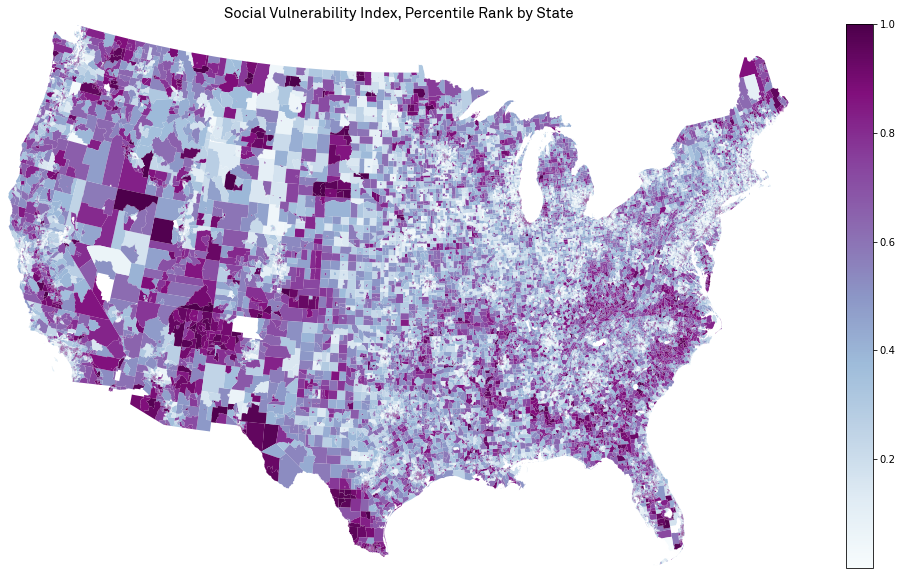

In [61]:
## for plotting -- reprojecting to albers usa
svi_occ_albers = svi_occupations.to_crs("ESRI:102008")

fig, ax = plt.subplots(figsize=(20,10))
svi_occ_albers.plot(ax=ax, column='RPL_ThemesStates', legend=True,cmap="BuPu")
ax.set_xlim(lower48_xlim)
ax.set_ylim(lower48_ylim)
ax.set_title("Social Vulnerability Index, Percentile Rank by State", fontname="Akkurat Pro", fontsize=15)
ax.set_axis_off()


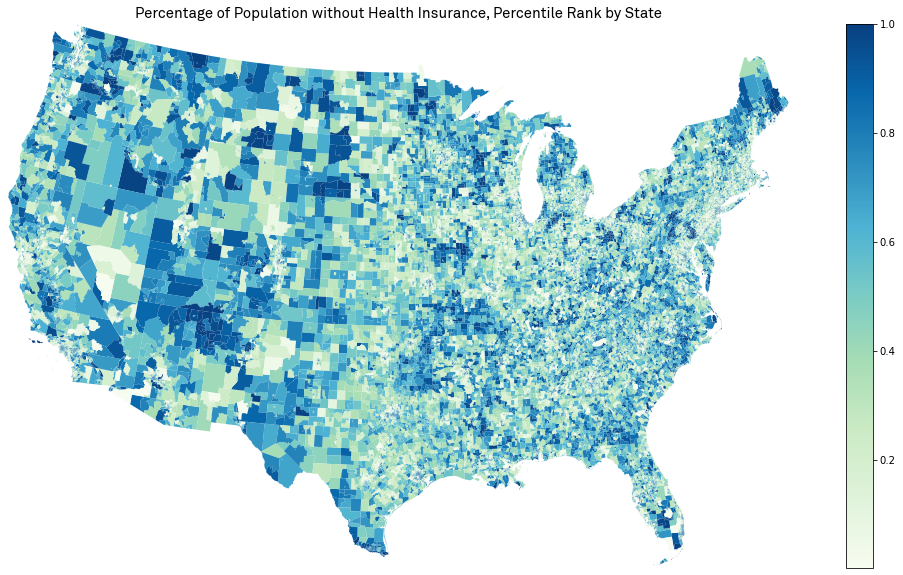

In [63]:

# svi_occ_albers['PER_UNINSUR'] = svi_occ_albers.groupby('STATE')['EP_UNINSUR'].rank(pct=True)
fig, ax = plt.subplots(figsize=(20,10))
svi_occ_albers.plot(ax=ax, column='RPL_Uninsur', legend=True,cmap="GnBu")
ax.set_xlim(lower48_xlim)
ax.set_ylim(lower48_ylim)
ax.set_title("Percentage of Population without Health Insurance, Percentile Rank by State", fontname="Akkurat Pro", fontsize=15)
ax.set_axis_off()


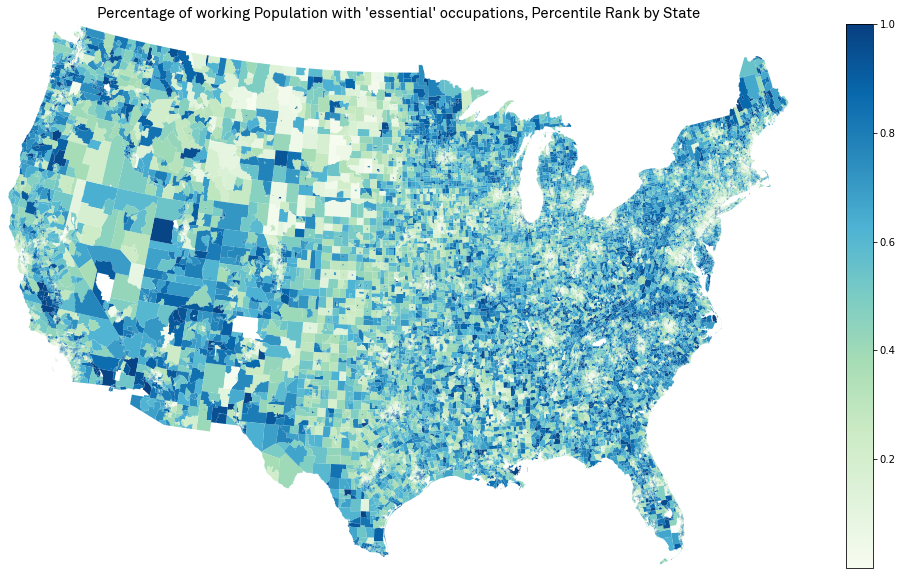

In [64]:

# svi_occ_albers['PER_UNINSUR'] = svi_occ_albers.groupby('STATE')['EP_UNINSUR'].rank(pct=True)
fig, ax = plt.subplots(figsize=(20,10))
svi_occ_albers.plot(ax=ax, column='RPL_essential', legend=True,cmap="GnBu")
ax.set_xlim(lower48_xlim)
ax.set_ylim(lower48_ylim)
ax.set_title("Percentage of working Population with 'essential' occupations, Percentile Rank by State", fontname="Akkurat Pro", fontsize=15)
ax.set_axis_off()


 ## IV. Essential work
 Judging by the historgram below of essential work it seems like we may need to refine the measure of essential work that we are using: 

In [75]:
import seaborn as sns
import numpy as np

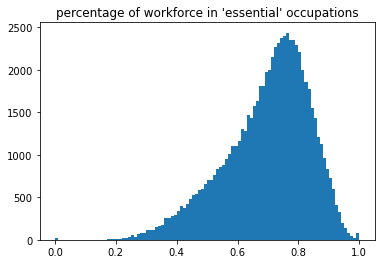

In [68]:
plt.hist(svi_occupations['pct_essential'], bins=100)
plt.title("percentage of workforce in 'essential' occupations")
plt.show()